In [ ]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import quantum_info
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

import numpy as np
import matplotlib.pyplot as plt

### Quantum Teleportation

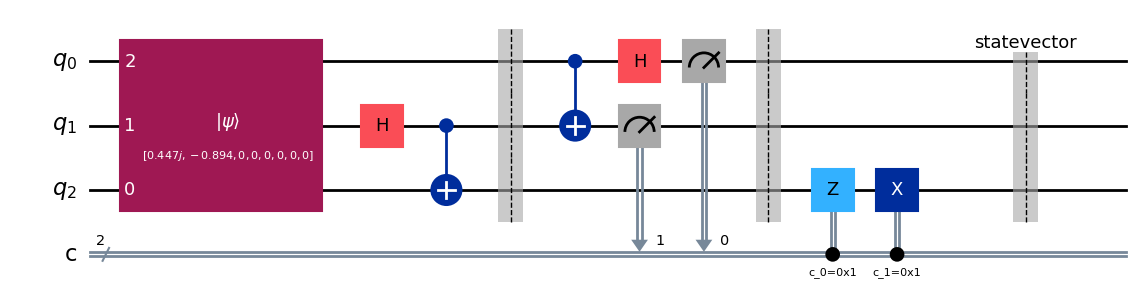

In [ ]:
circuit2 = QuantumCircuit(3, 2)

ket0 = quantum_info.Statevector(np.array([np.sqrt(0.2)*1j, -np.sqrt(0.8)]))
ket1 = quantum_info.Statevector([1, 0])
ket2 = quantum_info.Statevector([1, 0])
init_state = quantum_info.Statevector(ket2^ket1^ket0)

circuit2.initialize(init_state, [2,1,0])

circuit2.h(1)
circuit2.cx(1,2)
circuit2.barrier()

circuit2.cx(0,1)
circuit2.h(0)
circuit2.measure([0,1], [0,1])
circuit2.barrier()

circuit2.z(2).c_if(0, 1)
circuit2.x(2).c_if(1, 1)
circuit2.save_statevector()

circuit2.draw('mpl')

In [ ]:
init_state.draw('latex')

<IPython.core.display.Latex object>

In [ ]:
# final_state = init_state.evolve(circuit2)
# final_state.draw('latex')
sim_aer = AerSimulator()
job = sim_aer.run(circuit2, shots=1024)
result = job.result()
final_state = result.get_statevector()
final_state.draw('latex')

<IPython.core.display.Latex object>